In [1]:
%matplotlib inline

import numpy as np
import os
import cv2
import imageio

import matplotlib.pyplot as plt
import pandas as pd

from dataset import Dataset
from model import Model

In [2]:
%%capture
in_dir = "./data/images_rao_128x128"
out_dir = "./classification_results"

test_set = Dataset(scale=1.0, shuffle=False, data_dir=in_dir,
                   rf1_x=16, rf1_y=16, rf1_offset_x=8, rf1_offset_y=8,
                   rf1_layout_x=15, rf1_layout_y=15, gauss_mask_sigma=1.0)

iter_n = 30 # default: 30
epoch_n = 500

zero_pad_len = len(str(epoch_n))

model = Model(iteration=iter_n, dataset=test_set)

# parameters
model.k_r = 0.005 # default: 0.0005
model.k_U_init = 0.01  # default: 0.005
model.k_U_decay_cycle = 40 # default: 40
model.k_U_decay_rate = 1.015 # default: 1.015

model.sigma_sq0 = 1.0 # default: 1.0
model.sigma_sq1 = 10.0 # default: 10.0
model.sigma_sq2 = 10.0 # default: 10.0
model.sigma_sq3 = 2.0 # default: 2.0
model.alpha1 = 1.0  # default: 1.0
model.alpha2 = 0.05 # default: 0.05
model.alpha3 = 0.05 # default: 0.05

model.lambda1 = 0.02 # default: 0.02
model.lambda2 = 0.00001 # default: 0.0001
model.lambda3 = 0.02 # default: 0.0001

model.save(os.path.join(out_dir, "pretraining"))

In [3]:
%%capture

for i in range(epoch_n):
    # images are shuffled for each training epoch
    train_set = Dataset(scale=1.0, shuffle=True, data_dir=in_dir,
                        rf1_x=16, rf1_y=16, rf1_offset_x=8, rf1_offset_y=8,
                        rf1_layout_x=15, rf1_layout_y=15, gauss_mask_sigma=1.0)
    model.train(train_set)

    if i == 0 or i % 10 == 9:
        model.save(os.path.join(out_dir, "epoch_{:0>{}d}".format(i, zero_pad_len)))

In [4]:
%%capture

# target_v and response_v are vectors of target and actual activation, respectively
# target_i and response_i are the index of the highest value in their corresponding vectors
results = {"epoch": [], "target_v": [], "response_v": [], "target_i": [], "response_i": [], "accuracy": []}

for i in range(epoch_n):
    if i % 10 == 9:
        model.load(os.path.join(out_dir, "epoch_{:0>{}d}".format(i, zero_pad_len)))

        for j in range(len(test_set.rf2_patches)):
            inputs = test_set.get_rf1_patches(j)
            label = test_set.labels[j]
            r1, r2, r3, e1, e2, e3 = model.apply_input(inputs, label, training=False)

            target_i = np.argmax(label)

            if sum(r3 == r3.max()) != 1:
                response_i = None
            else:
                response_i = np.argmax(r3)

            if target_i == response_i:
                accuracy = 1
            else:
                accuracy = 0

            results["epoch"].append(i)
            results["target_v"].append(label)
            results["response_v"].append(r3)
            results["target_i"].append(target_i)
            results["response_i"].append(response_i)
            results["accuracy"].append(accuracy)

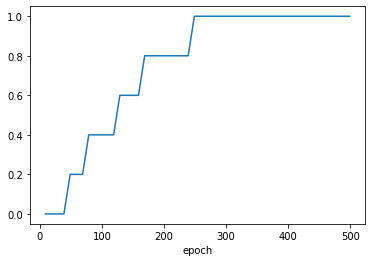

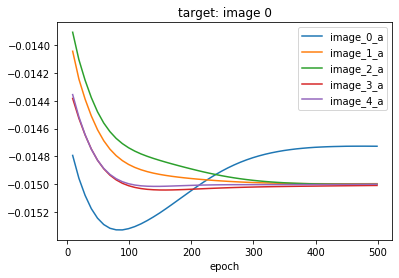

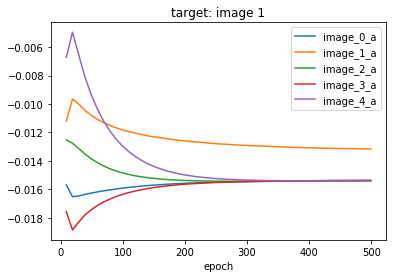

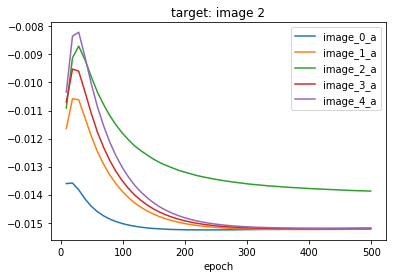

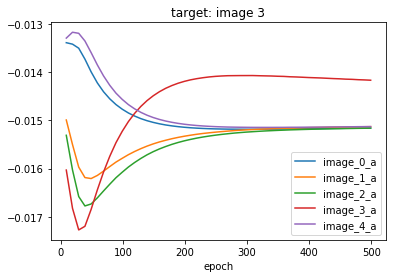

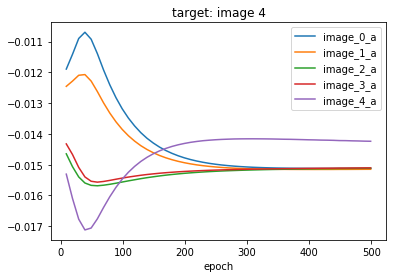

In [5]:
results_df = pd.DataFrame.from_dict(results)

results_df.groupby('epoch')['accuracy'].mean().plot();

pd.set_option('precision', 10)
vector_len = len(test_set.labels)

# extract activation of each node (corresponding to an image identity)
for i in range(vector_len):
    results_df['image_{}_a'.format(i)] = results_df.response_v.map(lambda x: x[i])

for i in range(vector_len):
    # select a specific target
    results_df_select = results_df[(results_df.target_i == i)]

    # plot
    results_df_select = results_df_select.filter(regex='epoch|image')
    results_df_select.plot(x='epoch',
                           title='target: image {}'.format(i));

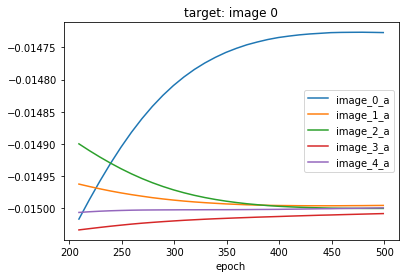

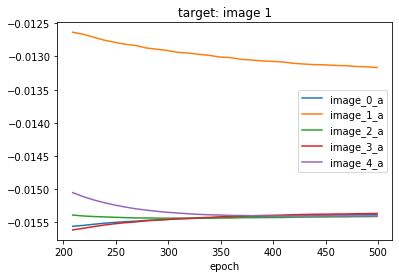

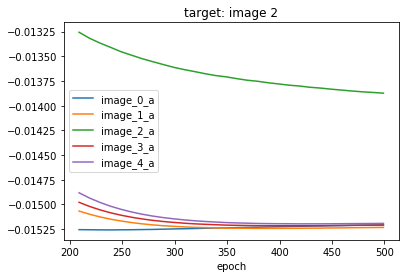

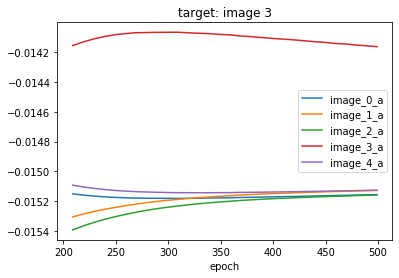

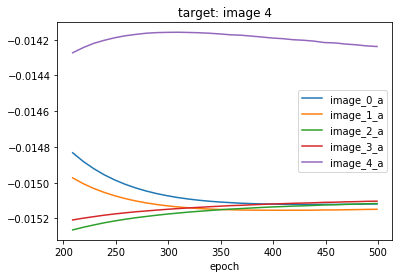

In [6]:
for i in range(vector_len):
    # select a specific target
    results_df_select = results_df[(results_df.target_i == i) & (results_df.epoch >= 200)]

    # plot
    results_df_select = results_df_select.filter(regex='epoch|image')
    results_df_select.plot(x='epoch',
                           title='target: image {}'.format(i));

loaded: ./classification_results/epoch_000


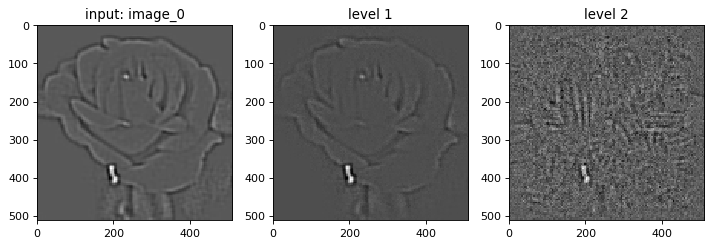

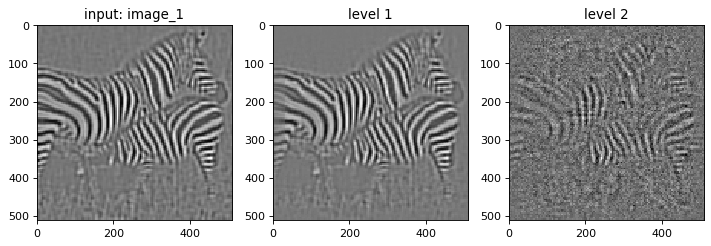

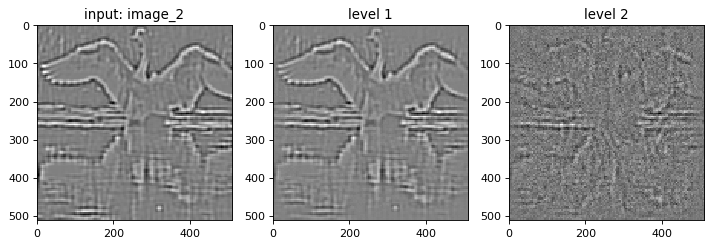

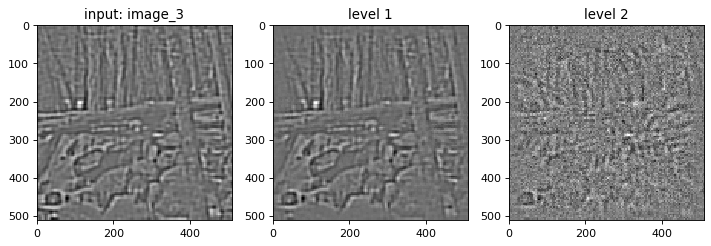

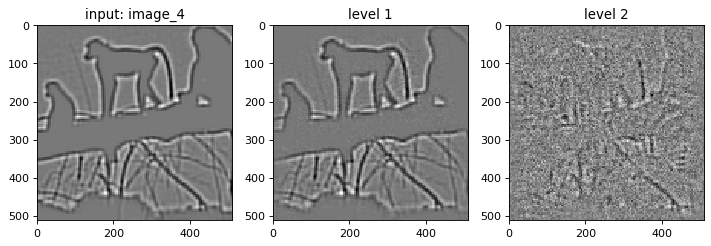

In [7]:
model.load(os.path.join(out_dir, "epoch_{:0>{}d}".format(0, zero_pad_len)))

for i in range(len(test_set.filtered_images)):
    filtered_img = test_set.filtered_images[i]
    filtered_img = cv2.resize(filtered_img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)
    filtered_img = cv2.normalize(src=filtered_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    inputs = test_set.get_rf1_patches(i)
    label = test_set.labels[i]
    r1, r2, r3, e1, e2, e3 = model.apply_input(inputs, label, training=False)
    level1_img = model.reconstruct(r1, level=1)
    level2_img = model.reconstruct(r2, level=2)
    level1_img = cv2.resize(level1_img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)
    level2_img = cv2.resize(level2_img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)
    level1_img = cv2.normalize(src=level1_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    level2_img = cv2.normalize(src=level2_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    plt.figure(figsize=(9, 3), dpi=80)

    plt.subplot(131)
    plt.title("input: image_{}".format(i))
    plt.imshow(filtered_img, cmap="gray")

    plt.subplot(132)
    plt.title("level 1")
    plt.imshow(level1_img, cmap="gray")
    
    plt.subplot(133)
    plt.title("level 2")
    plt.imshow(level2_img, cmap="gray")

    plt.tight_layout()

loaded: ./classification_results/epoch_499


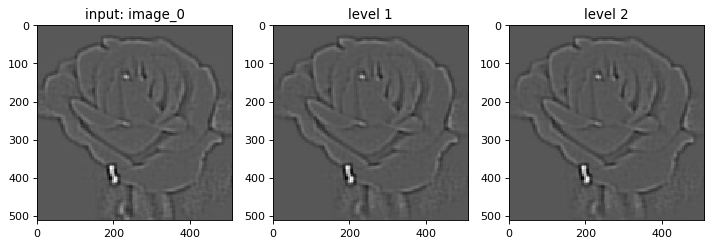

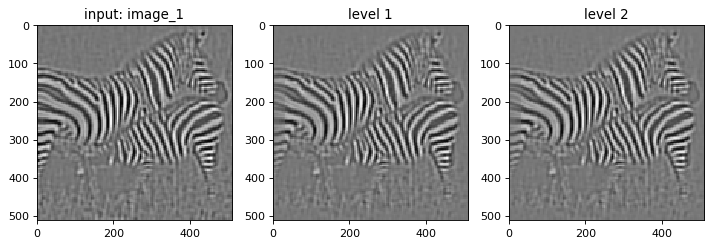

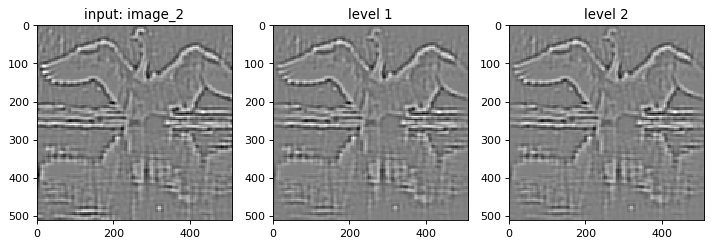

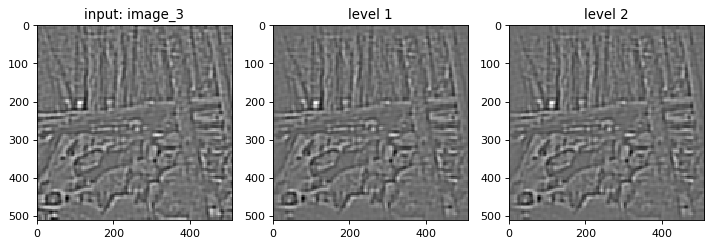

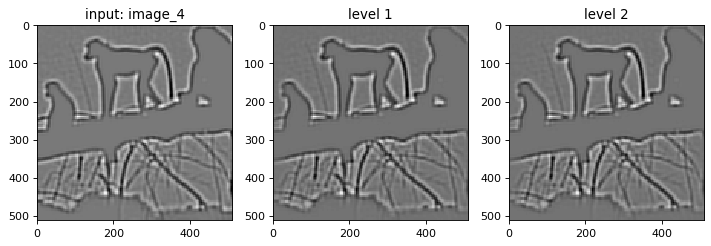

In [8]:
model.load(os.path.join(out_dir, "epoch_{:0>{}d}".format(max(range(epoch_n)), zero_pad_len)))

for i in range(len(test_set.filtered_images)):
    filtered_img = test_set.filtered_images[i]
    filtered_img = cv2.resize(filtered_img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)
    filtered_img = cv2.normalize(src=filtered_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    inputs = test_set.get_rf1_patches(i)
    label = test_set.labels[i]
    r1, r2, r3, e1, e2, e3 = model.apply_input(inputs, label, training=False)
    level1_img = model.reconstruct(r1, level=1)
    level2_img = model.reconstruct(r2, level=2)
    level1_img = cv2.resize(level1_img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)
    level2_img = cv2.resize(level2_img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)
    level1_img = cv2.normalize(src=level1_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    level2_img = cv2.normalize(src=level2_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    plt.figure(figsize=(9, 3), dpi=80)

    plt.subplot(131)
    plt.title("input: image_{}".format(i))
    plt.imshow(filtered_img, cmap="gray")

    plt.subplot(132)
    plt.title("level 1")
    plt.imshow(level1_img, cmap="gray")
    
    plt.subplot(133)
    plt.title("level 2")
    plt.imshow(level2_img, cmap="gray")

    plt.tight_layout()